In [2]:
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Open the HDF5 file
with h5py.File('hypercube.h5', 'r') as hdf_file:
    #Check weather data
    temperature = hdf_file['temperature'][:]
    rainfall = hdf_file['rainfall'][:]
    print(temperature)
    print(rainfall)

    # Check altitude data
    altitude_data = hdf_file['altitude'][:]
    altitude_data = np.where(np.isfinite(altitude_data), np.where(altitude_data < -500, 0, altitude_data), np.nan)
    altitude_data = np.where(np.isnan(altitude_data), 0, altitude_data)
    plt.figure(figsize=(10, 8))
    plt.subplot(3,2, 1)
    plt.imshow(altitude_data)
    plt.axis("off")
    plt.title('Altitude')
    plt.colorbar()
    
    # Check mask data
    mask_data = hdf_file['mask'][:]
    
    plt.subplot(3,2, 2)
    plt.imshow(mask_data, cmap='gray')
    plt.title('Mask')

    # Check monthly hypercubes data and wplot sample bands for a selected month
    selected_month = 1  # Change this value to visualize data for a different month
    dataset_name = f'{selected_month}'
    
    if dataset_name in hdf_file:
        month_data = hdf_file[dataset_name][:]
        plt.subplot(3,2, 3)
        plt.imshow(month_data[:, :, 0], interpolation='nearest')  # Plot the first band (e.g., B02)
        plt.title(f'Month {selected_month} - Band 1 (B02)')
        plt.colorbar()

        plt.subplot(3,2, 4)
        plt.imshow(month_data[:, :, 4], interpolation='nearest')  # Plot the NDVI band
        plt.title(f'Month {selected_month} - NDVI')
        plt.colorbar()
    else:
        print(f"Month {selected_month} data not found.")

    # Check metadata
    if 'meta' in hdf_file.attrs:
        meta_serialized = hdf_file.attrs['meta']
        meta = json.loads(meta_serialized)
        print("\nMetadata:")
        for key, value in meta.items():
            print(f"  - {key}: {value}")
    else:
        print("\nMetadata not found.")
    
    #check categorical mask 
    if 'categorical_mask' in hdf_file:
        categorical_mask = hdf_file['categorical_mask']
        plt.subplot(3, 2, 5)
        plt.imshow(categorical_mask[:, :, 0], interpolation='nearest')  
        plt.title(f'Categorical mask : Limite')
        plt.subplot(3, 2, 6)
        plt.imshow(categorical_mask[:, :, 1], interpolation='nearest')  
        plt.title(f'Categorical mask : Assez_limite')
    else:
        print("\nCategorical not found.")
        
    plt.tight_layout()
    plt.show()


<HDF5 dataset "temperature": shape (12,), type "<f8">
<HDF5 dataset "rainfall": shape (12,), type "<f8">


KeyError: "Unable to synchronously open object (object 'altitude' doesn't exist)"

In [ ]:
with h5py.File('hypercube.h5', 'r') as hdf_file:
    band = hdf_file["6"][:]
    print(type(band))
    print(band.shape)

<class 'numpy.ndarray'>
(10980, 10980, 5)


692.0 17232.0 559.47266 2206.3657
950.0 17840.0 396.87048 2047.7644
383.0 18672.0 312.52222 1705.0074
55.36 255.0 41.69556 175.33224
76.0 255.0 30.284132 163.48912
30.64 255.0 24.086735 136.28099
0.0 1.0 0.208854 0.60094285
0.0 1.0 0.16918497 0.48876613
0.0 1.0 0.10735756 0.4708549


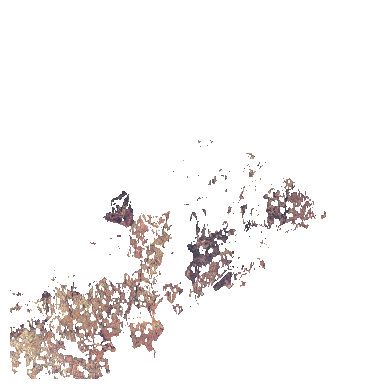

In [ ]:
brightness_factor = 1.5

r = band[:,:,2]
g = band[:,:,1]
b = band[:,:,0]

def normalize(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

def stats(x):
    print(np.nanmin(x), np.nanmax(x), np.nanstd(x), np.nanmean(x))

def brighten(band):
    alpha=0.08
    beta=0
    return np.clip(alpha*band+beta, 0,255)

stats(r)
stats(g)
stats(b)

r = brighten(r)
g = brighten(g)
b = brighten(b)
 
stats(r)
stats(g)
stats(b)

r = normalize(r)
g = normalize(g)
b = normalize(b)

stats(r)
stats(g)
stats(b)

rgb = np.dstack([r,g,b])

plt.imshow(rgb)
plt.axis("off")
plt.show()

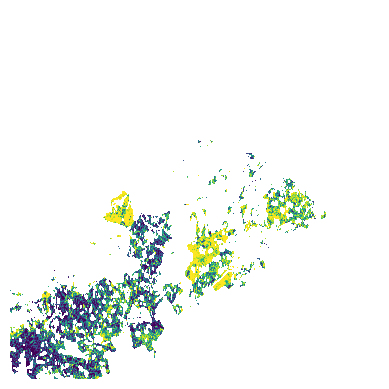

In [ ]:
from sklearn.cluster import KMeans

band_reshaped = band.reshape(band.shape[0]*band.shape[1], band.shape[2]) # N*M, 5
X = band_reshaped[~np.isnan(band_reshaped).any(axis=1)]

num_clusters = 2
seed = 1
kmeans = KMeans(n_clusters=num_clusters, random_state=seed)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

Y = np.full((band.shape[0]*band.shape[1]), np.nan)
Y[~np.isnan(band_reshaped).any(axis=1)] = kmeans_labels

labels = Y.reshape(band.shape[0], band.shape[1])
plt.imshow(labels)
plt.axis("off")
plt.show()